# K-Means

## Imports

In [24]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import linalg
import seaborn as sns

sys.path.append('../')

from utils.scalers import MinMaxScaler


sns.set_palette('tab10')

## Process

In [25]:
# Reading the dataset
data = np.genfromtxt('./data/quake.csv', delimiter=',')
X = data[:, :]
print('Shape:', data.shape)
data[:3, :]

Shape: (2178, 2)


array([[-52.26,  28.3 ],
       [ 45.53, 150.93],
       [ 41.85, 142.78]])

In [26]:
scaler = MinMaxScaler()
X_norm = scaler.fit_transform(X)
X_norm

array([[0.09838219, 0.57856428],
       [0.77447456, 0.91924103],
       [0.74903208, 0.89659962],
       ...,
       [0.65237832, 0.88751528],
       [0.71155973, 0.89159907],
       [0.62576051, 0.83950995]])

In [27]:
class MyKmeans():

    def __init__(
        self,
        K, 
        distance='euclidean',
        tol=1e-6,
        n_init=20,
        random_state=None
    ):
        self.K = K
        self.distance = distance
        self.tol = tol
        self.random_state = np.random.RandomState(random_state)
        self.n_init = n_init

        
    def get_distance(self, X, y):       
        if self.distance == 'euclidean':
            return (np.sum((X - y) ** 2, axis=1) ** (1/2))
        elif self.distance == 'mahalanobis':
            distances = np.sqrt(
                np.diag(
                    np.dot(np.dot((X-y), self.sigma_inv), (X-y).T)
                )
            )
            return distances

    def get_cov_matrix(self, X):
        
        mu = np.mean(X, axis=0).reshape(-1, 1)
        
        n_features = X.shape[1]
        n_rows = X.shape[0]
        sigma=np.zeros((n_features, n_features))

        for i in range(n_rows):
            x_i = X[i,:].reshape(n_features, 1)
            sigma += (x_i-mu) @ (x_i-mu).T

        return sigma/(n_rows-1)

    def initialize_centroids(self, X):     
        # K-means++
        centroids = []
        
        # First chosen centroid
        centroids.append(X[np.random.choice(X.shape[0]), :])

        for _ in range(self.K-1):
            distances_to_centroids = np.zeros((X.shape[0], len(centroids)))
            for k_centroid in range(len(centroids)):
                distance = self.get_distance(
                    X, centroids[k_centroid]
                )**2
                distances_to_centroids[:, k_centroid] = distance

            distances_to_clusters = np.amin(distances_to_centroids, axis=1)

            i_new_centroid = self.random_state.choice(
                np.arange(0, len(distances_to_clusters)),
                p=distances_to_clusters.ravel() / distances_to_clusters.sum()
            )

            centroids.append(X[i_new_centroid, :])

        self.centroids = np.array(centroids)


    def define_clusters(self, X):
        clusters = np.zeros((X.shape[0], 1))

        distances_to_centroids = np.zeros((X.shape[0], len(self.centroids)))
        for k_centroid in range(len(self.centroids)):
            distance = self.get_distance(
                X, self.centroids[k_centroid]
            )
            distances_to_centroids[:, k_centroid] = distance

        clusters = np.argmin(distances_to_centroids, axis=1)

        self.clusters = clusters.reshape(-1, 1)
        return clusters


    def plot(self, X):

        plt.figure(figsize=(10, 10))

        space = (X.max() - X.min())/20
        plt.xlim([X.min()-space, X.max()+space])
        plt.ylim([X.min()-space, X.max()+space])
        sns.scatterplot(
            x = X[:, 0], 
            y = X[:, 1], 
            hue=self.clusters[:, 0], 
            palette='tab10'
        )
        plt.scatter(x = self.centroids[:, 0], y = self.centroids[:, 1], marker='X', s=500, c='red')
        plt.gca().set_aspect('equal', adjustable='box')


    def reconstruction_error(self, X):
        distances = np.zeros((0,))
        for i_cluster in range(len(self.centroids)):
            data = X[self.clusters[:, 0] == i_cluster]
            distance = self.get_distance(
                data, self.centroids[i_cluster, :]
            )**2
            distances = np.concatenate([distances, distance])

        return np.sum(distances)


    def fit(self, X):
        errors = [np.inf]
        
        best_rec_error = np.inf

        if self.distance == 'mahalanobis':
            self.sigma_inv = np.linalg.pinv(self.get_cov_matrix(X))

        # INITIALIZING 'n_init' times
        for i in range(self.n_init):
            self.initialize_centroids(X)
            self.define_clusters(X)
            
            count = 0
            while True:
                count+=1

                self.define_clusters(X)
                actual_rec_error = self.reconstruction_error(X)
                errors.append(actual_rec_error)

                if np.abs(errors[-2] - errors[-1]) < self.tol:
                    break

                for i_cluster in range(len(self.centroids)):
                    data = X[self.clusters[:, 0] == i_cluster]
                    self.centroids[i_cluster, :] = data.mean(axis=0) 

            if actual_rec_error < best_rec_error:
                best_rec_error = actual_rec_error
                best_centroids = self.centroids

        self.centroids = best_centroids
        self.define_clusters(X)


    def predict(self, X):
        return self.define_clusters(X)
    

    def davies_boudin(self, X):
        within_cluster_scatter_list = []
        for i_cluster in range(len(self.centroids)):
            cluster_data = X[self.clusters[:, 0] == i_cluster]

            # within cluster scatter
            within_cluster_scatter = self.get_distance(
                cluster_data, self.centroids[i_cluster]
            ).sum()
            within_cluster_scatter_list.append(
                within_cluster_scatter / cluster_data.shape[0]
            )

        db_index = []
        for i_cluster in range(len(self.centroids)):
            maximum_value = -np.inf
            for j_cluster in range(len(self.centroids)):
                if i_cluster != j_cluster:
                    value = within_cluster_scatter_list[i_cluster] + \
                        within_cluster_scatter_list[j_cluster]
                    value = value / self.get_distance(
                        self.centroids[[i_cluster]], self.centroids[[j_cluster]]
                    )
                    maximum_value = max(value, maximum_value)
            db_index.append(maximum_value)
        
        db_index = sum(db_index) / len(self.centroids)

        return db_index[0]
    

## Euclidean Distance

### With Normalization

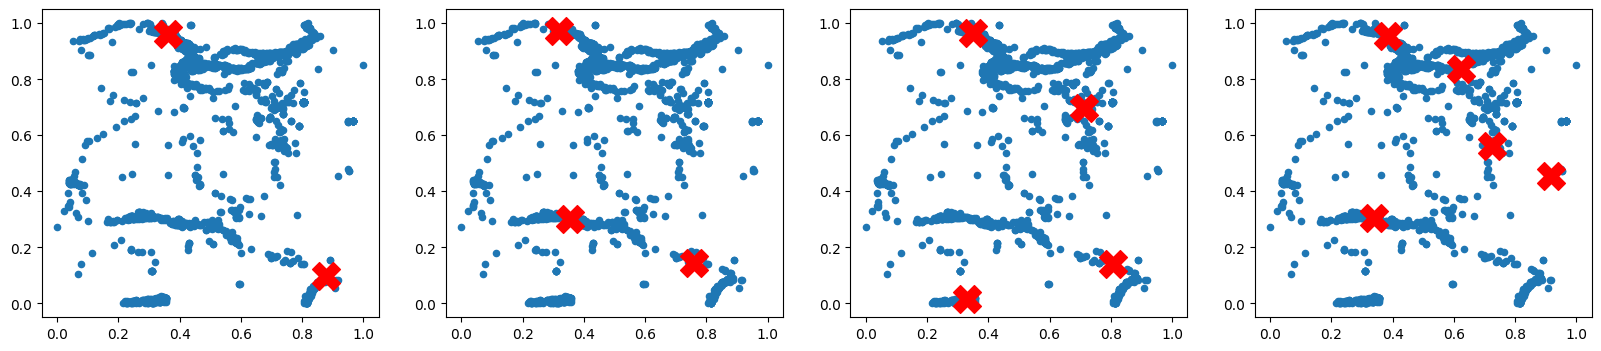

In [28]:
# Check k-means++ initialization
fig, ax = plt.subplots(1, 4, figsize=(20,4))

for i in range(4):
    my_kmeans = MyKmeans(i+2)
    my_kmeans.initialize_centroids(X_norm)

    ax[i].scatter(x = X_norm[:, 0], y = X_norm[:, 1], s=20)
    ax[i].scatter(x = np.array(my_kmeans.centroids)[:, 0], y = np.array(my_kmeans.centroids)[:, 1], marker='X', s=400, c='red')

#### My K-Means - Selecting best K

DB-Index (K=4): 0.725020533331885
DB-Index (K=5): 0.6341926514401441
DB-Index (K=6): 0.6391979121202184
DB-Index (K=7): 0.6175861816620095
DB-Index (K=8): 0.6829593846495698
DB-Index (K=9): 0.6592368440379759
DB-Index (K=10): 0.6161107733599337
DB-Index (K=11): 0.5962727823132493
DB-Index (K=12): 0.659936883880221
DB-Index (K=13): 0.6257033919477598
DB-Index (K=14): 0.6187892135164915
DB-Index (K=15): 0.6103288094652052
DB-Index (K=16): 0.6269100951970782
DB-Index (K=17): 0.6426154000737494
DB-Index (K=18): 0.6130536409197308
DB-Index (K=19): 0.5979903569892118
DB-Index (K=20): 0.6984380046775283


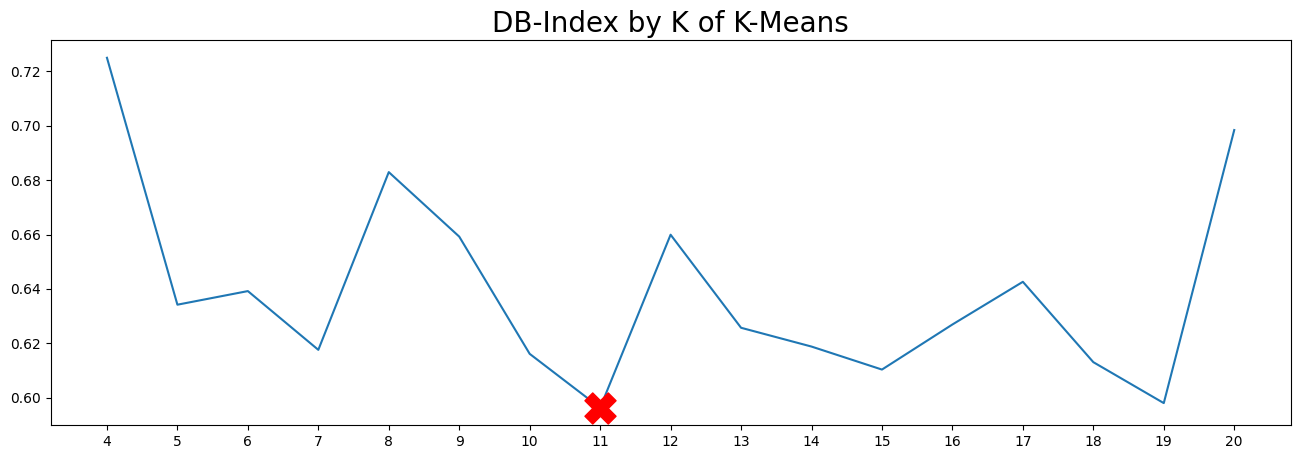

In [29]:
db_index_list = []
for i in range(4, 21):
    my_kmeans = MyKmeans(K=i, distance='euclidean', n_init=20, tol=1e-6)
    my_kmeans.fit(X_norm)
    db_index = my_kmeans.davies_boudin(X_norm)
    db_index_list.append(db_index)
    print(f'DB-Index (K={i}):', db_index)

plt.figure(figsize=(16, 5))
plt.title('DB-Index by K of K-Means', fontsize=20)
plt.plot(range(4, 21), db_index_list)
plt.scatter(x = np.argmin(db_index_list)+4, y=np.min(db_index_list), c='red', s=500, marker='X', zorder=100)
plt.xticks(range(4, 21))
plt.show()
    

#### Sklearn - Selecting best K

In [30]:
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score

DB-Index (K=4): 0.7250205333318851
DB-Index (K=5): 0.6341926514401455
DB-Index (K=6): 0.6391278409584096
DB-Index (K=7): 0.6175861816620121
DB-Index (K=8): 0.6817305575553034
DB-Index (K=9): 0.6598453743304258
DB-Index (K=10): 0.6168088995817465
DB-Index (K=11): 0.5975487376929682
DB-Index (K=12): 0.660138310411505
DB-Index (K=13): 0.6538041408362572
DB-Index (K=14): 0.6166488659805323
DB-Index (K=15): 0.6363771558729386
DB-Index (K=16): 0.6271278189037504
DB-Index (K=17): 0.6401303702905218
DB-Index (K=18): 0.6409537589870026
DB-Index (K=19): 0.6627268447263674
DB-Index (K=20): 0.5903085158873569


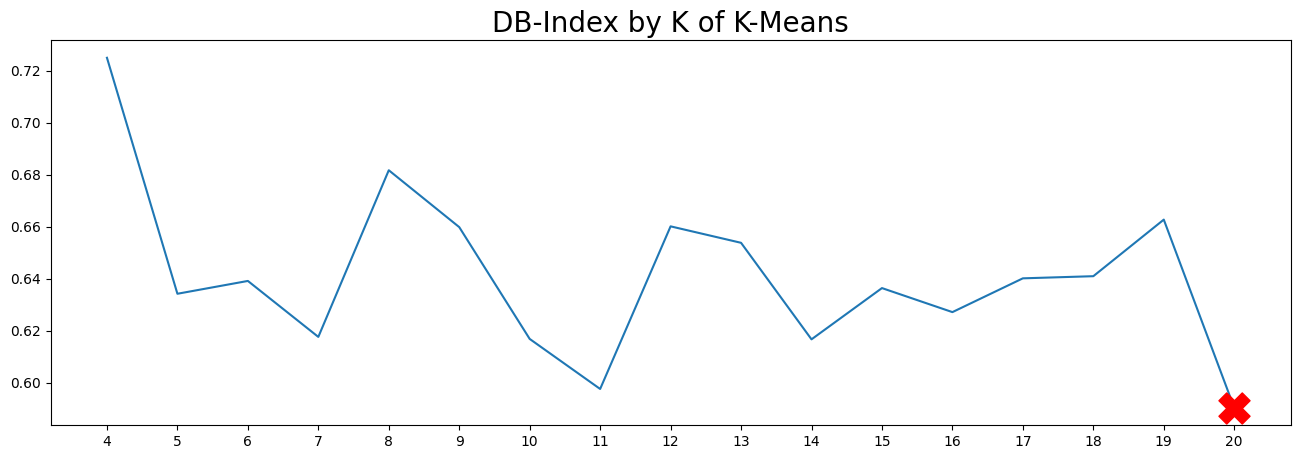

In [31]:
db_index_list = []
for i in range(4, 21):
    kmeans = KMeans(i, n_init=20, tol=1e-6)
    kmeans.fit(X_norm)
    db_index = davies_bouldin_score(X_norm, kmeans.labels_)
    db_index_list.append(db_index)
    print(f'DB-Index (K={i}):', db_index)

plt.figure(figsize=(16, 5))
plt.title('DB-Index by K of K-Means', fontsize=20)
plt.plot(range(4, 21), db_index_list)
plt.scatter(x = np.argmin(db_index_list)+4, y=np.min(db_index_list), c='red', s=500, marker='X', zorder=100)
plt.xticks(range(4, 21))
plt.show()

#### My K-Means - Fitting and Ploting

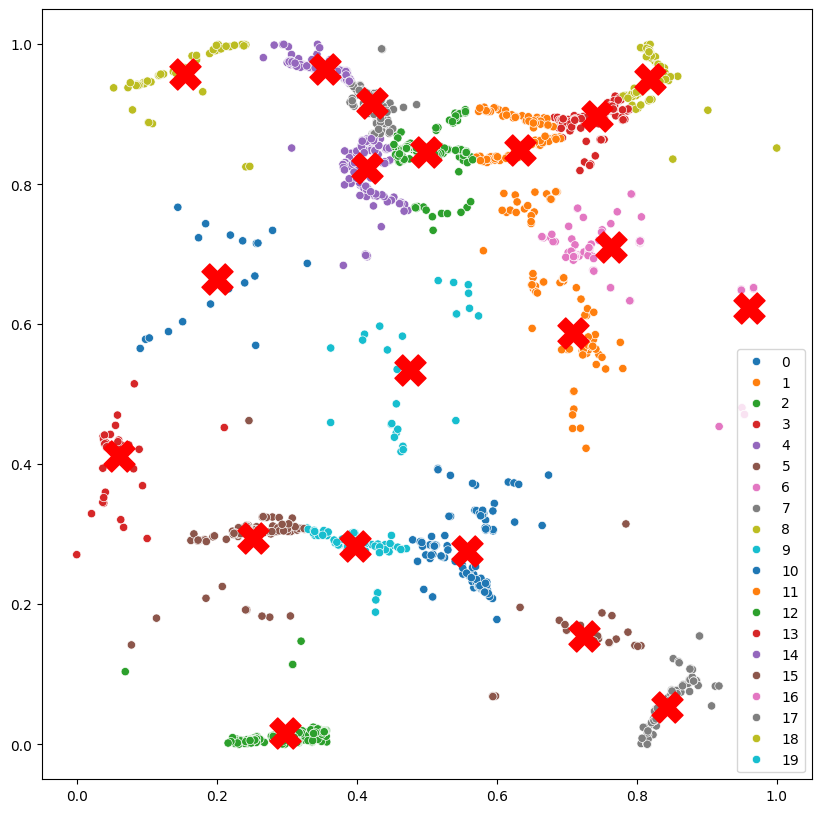

In [32]:
my_kmeans = MyKmeans(K=20, distance='euclidean', n_init=20, tol=1e-6)
my_kmeans.fit(X_norm)
my_kmeans.plot(X_norm)

#### Sklearn - Fitting and Ploting

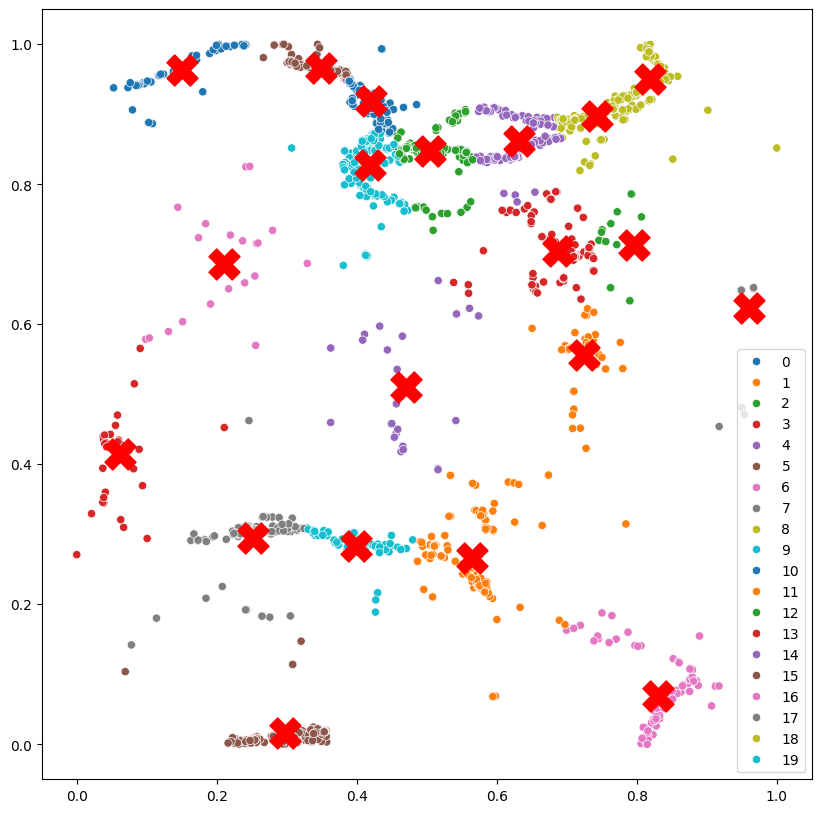

In [33]:
kmeans = KMeans(20, n_init=20, tol=1e-6)
kmeans.fit(X_norm)

plt.figure(figsize=(10, 10))

space = (X_norm.max() - X_norm.min())/20
plt.xlim([X_norm.min()-space, X_norm.max()+space])
plt.ylim([X_norm.min()-space, X_norm.max()+space])
sns.scatterplot(
    x = X_norm[:, 0], 
    y = X_norm[:, 1], 
    hue=kmeans.labels_, 
    palette='tab10'
)
plt.scatter(x = kmeans.cluster_centers_[:, 0], y = kmeans.cluster_centers_[:, 1], marker='X', s=500, c='red')
plt.gca().set_aspect('equal', adjustable='box')

### Without Normalization

#### My K-Means

DB-Index (K=4): 0.6936230650389132
DB-Index (K=5): 0.6922949444576798
DB-Index (K=6): 0.5502776092107089
DB-Index (K=7): 0.5318004105584321
DB-Index (K=8): 0.5798353301464462
DB-Index (K=9): 0.5726874362747304
DB-Index (K=10): 0.6225111541686826
DB-Index (K=11): 0.6486331335019645
DB-Index (K=12): 0.6536738556785614
DB-Index (K=13): 0.6554942161135913
DB-Index (K=14): 0.6200660098737848
DB-Index (K=15): 0.7428193981353731
DB-Index (K=16): 0.6260496712139089
DB-Index (K=17): 0.6116054786715379
DB-Index (K=18): 0.6332560897949182
DB-Index (K=19): 0.5937966923460815
DB-Index (K=20): 0.6615067511242331


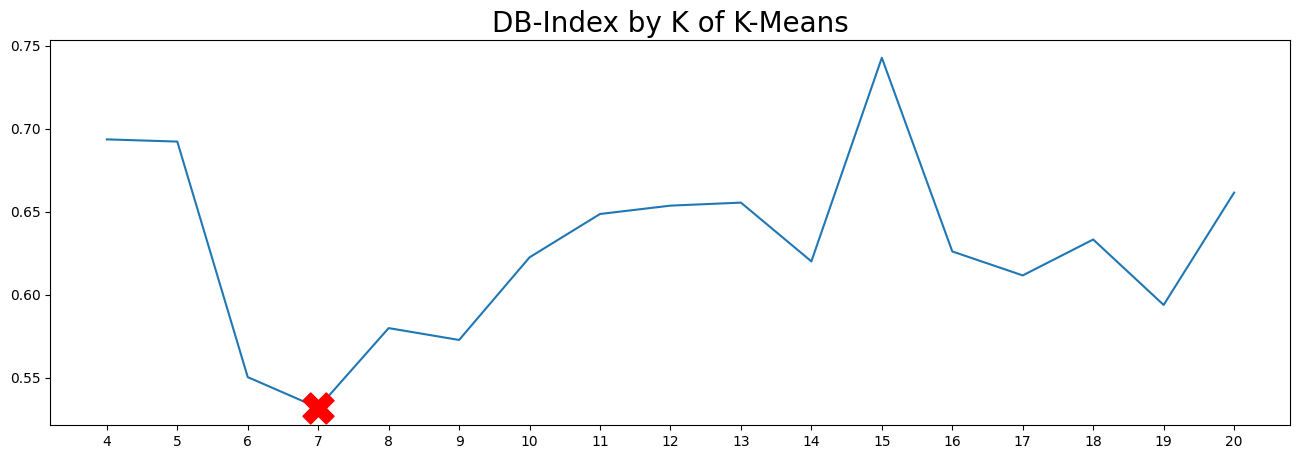

In [34]:
db_index_list = []
for i in range(4, 21):
    my_kmeans = MyKmeans(K=i, distance='euclidean', n_init=20, tol=1e-6)
    my_kmeans.fit(X)
    db_index = my_kmeans.davies_boudin(X)
    db_index_list.append(db_index)
    print(f'DB-Index (K={i}):', db_index)

plt.figure(figsize=(16, 5))
plt.title('DB-Index by K of K-Means', fontsize=20)
plt.plot(range(4, 21), db_index_list)
plt.scatter(x = np.argmin(db_index_list)+4, y=np.min(db_index_list), c='red', s=500, marker='X', zorder=100)
plt.xticks(range(4, 21))
plt.show()
    

#### Sklearn

DB-Index (K=4): 0.6936230650389128
DB-Index (K=5): 0.6922949444576803
DB-Index (K=6): 0.5502776092107097
DB-Index (K=7): 0.5318004105584326
DB-Index (K=8): 0.5798353301464467
DB-Index (K=9): 0.6308226142079932
DB-Index (K=10): 0.622752217944309
DB-Index (K=11): 0.6415049517616143
DB-Index (K=12): 0.6565328765150039
DB-Index (K=13): 0.6375786423301185
DB-Index (K=14): 0.6877962190144954
DB-Index (K=15): 0.6053761450278087
DB-Index (K=16): 0.6269204876059818
DB-Index (K=17): 0.6304489502264722
DB-Index (K=18): 0.6642034688817424
DB-Index (K=19): 0.6012620402572487
DB-Index (K=20): 0.6447156626079649


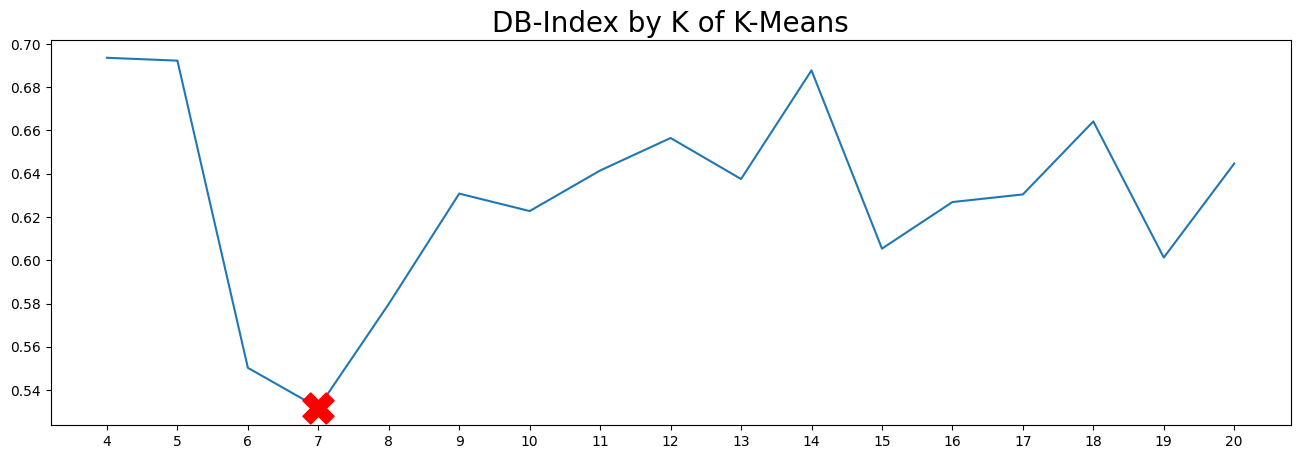

In [35]:
db_index_list = []
for i in range(4, 21):
    kmeans = KMeans(i, n_init=20, tol=1e-6)
    kmeans.fit(X)
    db_index = davies_bouldin_score(X, kmeans.labels_)
    db_index_list.append(db_index)
    print(f'DB-Index (K={i}):', db_index)

plt.figure(figsize=(16, 5))
plt.title('DB-Index by K of K-Means', fontsize=20)
plt.plot(range(4, 21), db_index_list)
plt.scatter(x = np.argmin(db_index_list)+4, y=np.min(db_index_list), c='red', s=500, marker='X', zorder=100)
plt.xticks(range(4, 21))
plt.show()

#### My K-Means - Fitting and Ploting

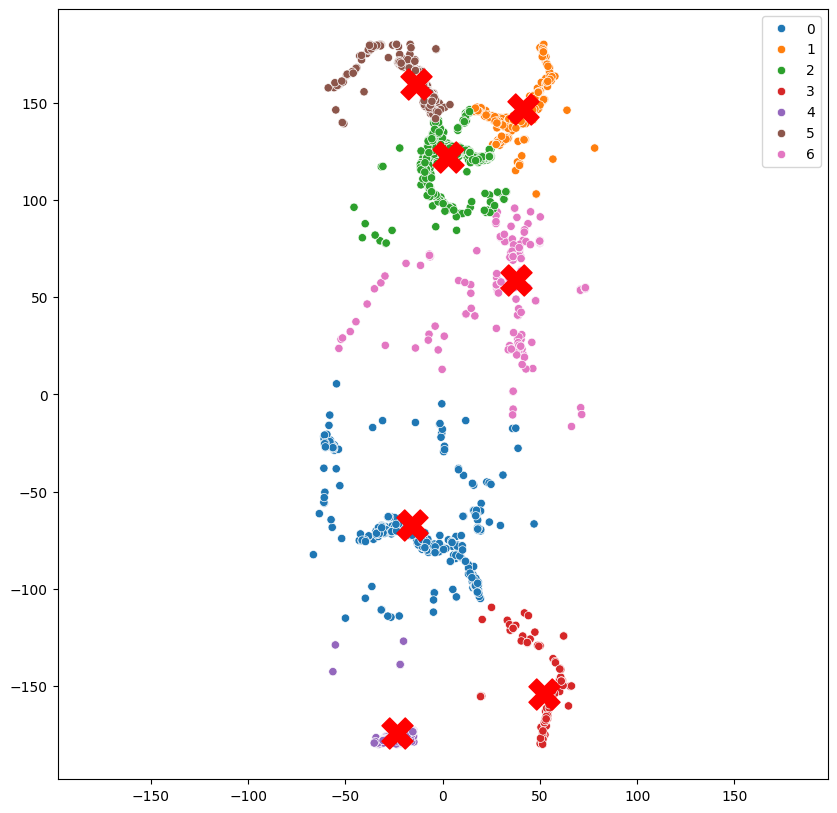

In [36]:
my_kmeans = MyKmeans(K=7, distance='euclidean', n_init=20, tol=1e-6)
my_kmeans.fit(X)
my_kmeans.plot(X)

#### Sklearn - Fitting and Ploting

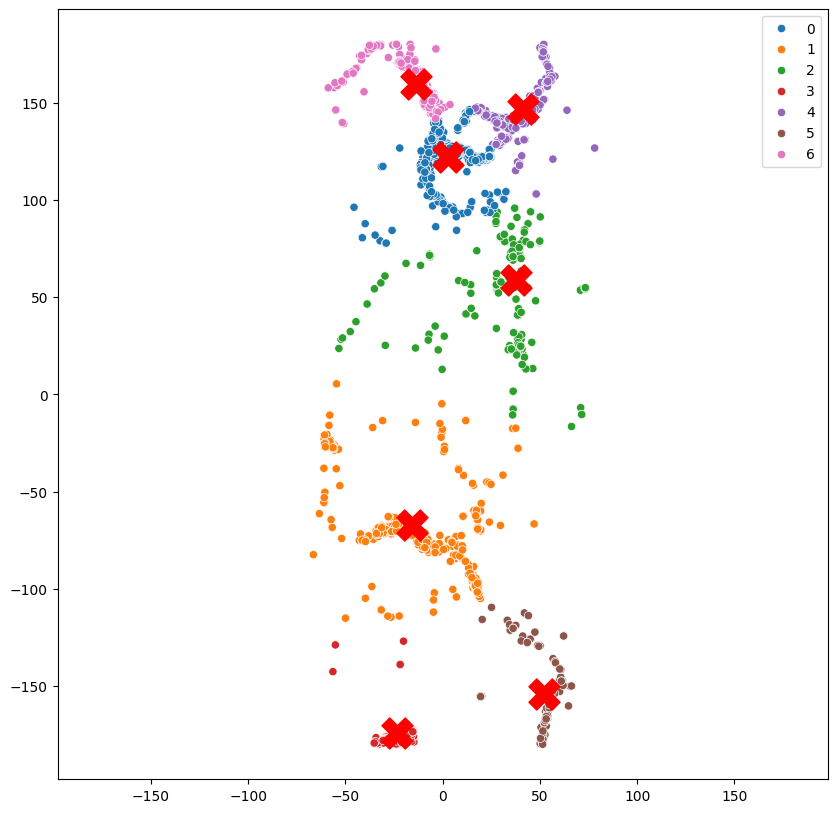

In [37]:
kmeans = KMeans(7, n_init=20, tol=1e-6)
kmeans.fit(X)

plt.figure(figsize=(10, 10))

space = (X.max() - X.min())/20
plt.xlim([X.min()-space, X.max()+space])
plt.ylim([X.min()-space, X.max()+space])
sns.scatterplot(
    x = X[:, 0], 
    y = X[:, 1], 
    hue=kmeans.labels_, 
    palette='tab10'
)
plt.scatter(x = kmeans.cluster_centers_[:, 0], y = kmeans.cluster_centers_[:, 1], marker='X', s=500, c='red')
plt.gca().set_aspect('equal', adjustable='box')

## Mahalanobis Distance

### With Normalization

DB-Index (K=10): 0.6103853524015048
DB-Index (K=14): 0.5815167531388951


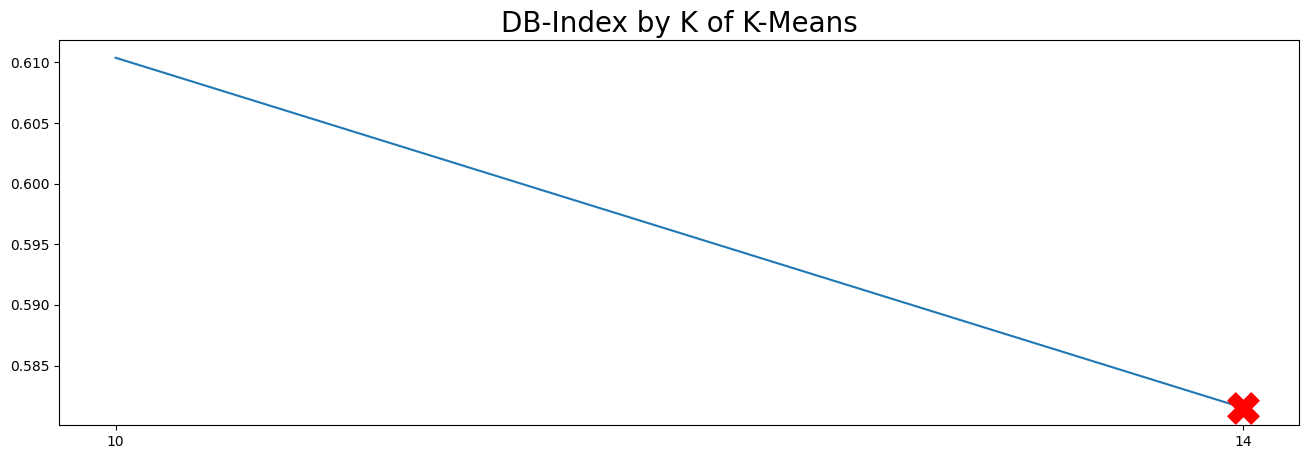

In [38]:
db_index_list = []

k_test = [x for x in range(4, 18, 4)]
for i in k_test:
    my_kmeans = MyKmeans(K=i, distance='mahalanobis', n_init=20, tol=1e-6)
    my_kmeans.fit(X_norm)
    db_index = my_kmeans.davies_boudin(X_norm)
    db_index_list.append(db_index)
    print(f'DB-Index (K={i}):', db_index)

K = k_test[np.argmin(db_index_list)]

plt.figure(figsize=(16, 5))
plt.title('DB-Index by K of K-Means', fontsize=20)
plt.plot(k_test, db_index_list)
plt.scatter(x=K , y=np.min(db_index_list), c='red', s=500, marker='X', zorder=100)
plt.xticks(k_test)
plt.show()
    

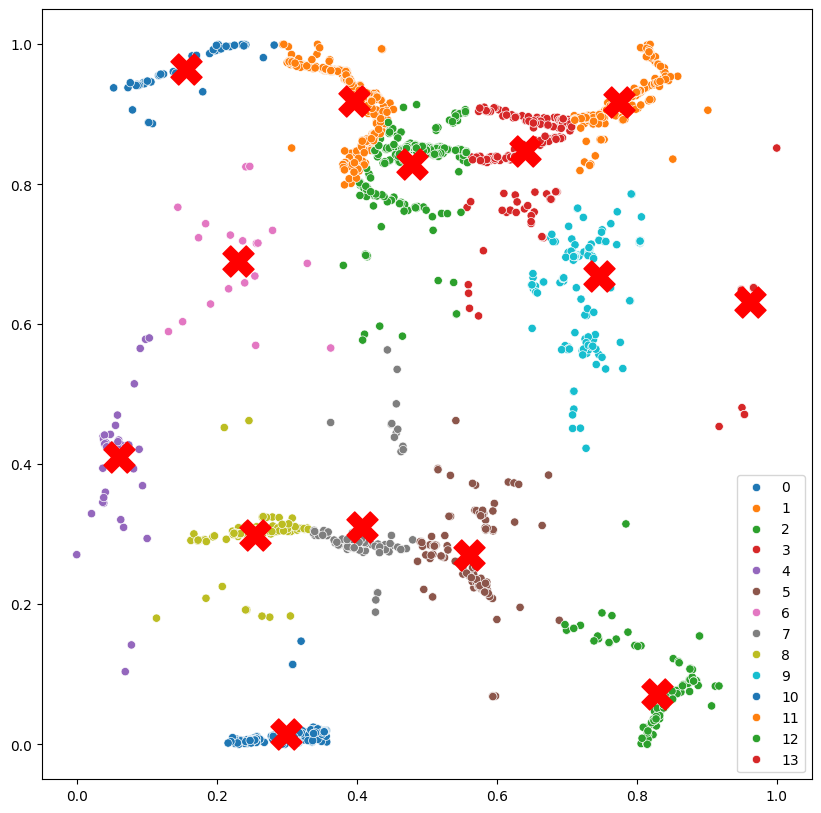

In [47]:
my_kmeans = MyKmeans(K=int(K), distance='mahalanobis', n_init=20, tol=1e-6)
my_kmeans.fit(X_norm)
my_kmeans.plot(X_norm)

### Without Normalization

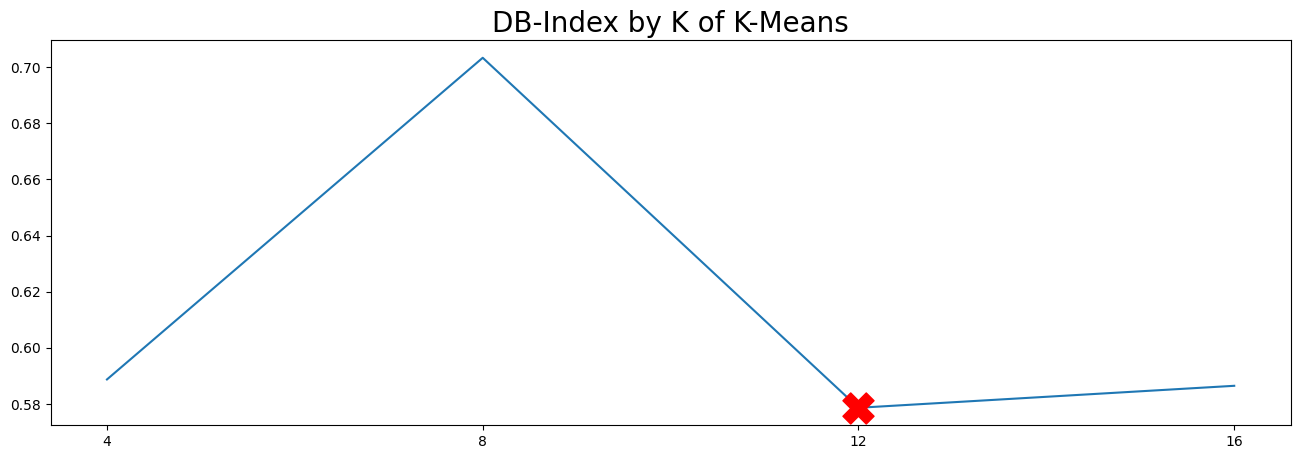

In [45]:
db_index_list = []

k_test = [x for x in range(4, 18, 4)]
for i in k_test:
    my_kmeans = MyKmeans(K=i, distance='mahalanobis', n_init=20, tol=1e-6)
    my_kmeans.fit(X)
    db_index = my_kmeans.davies_boudin(X)
    db_index_list.append(db_index)
    print(f'DB-Index (K={i}):', db_index)

K = k_test[np.argmin(db_index_list)]

plt.figure(figsize=(16, 5))
plt.title('DB-Index by K of K-Means', fontsize=20)
plt.plot(k_test, db_index_list)
plt.scatter(x = K, y=np.min(db_index_list), c='red', s=500, marker='X', zorder=100)
plt.xticks(k_test)
plt.show()
    

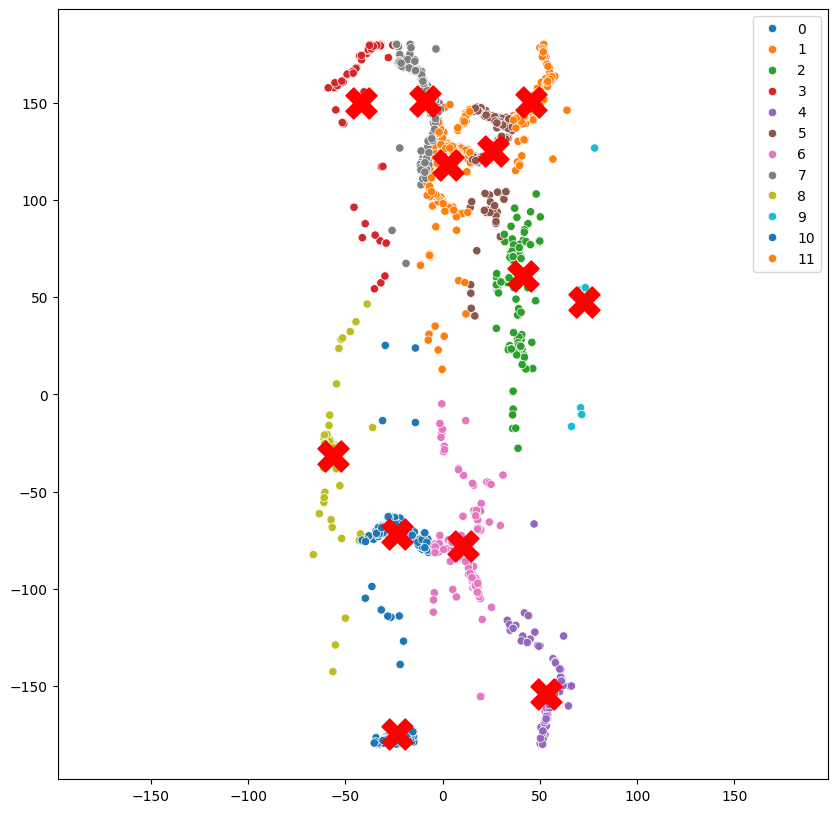

In [46]:
my_kmeans = MyKmeans(K=int(K), distance='mahalanobis', n_init=20, tol=1e-6)
my_kmeans.fit(X)
my_kmeans.plot(X)